In [1]:
# Setup ipython environment
%load_ext autoreload
%autoreload 2
%matplotlib inline
from matplotlib.pyplot import *
from numpy import *
from positive import *
from nrutils import scsearch, gwylm
from glob import glob
import xcp
from xcp import determine_data_fitting_region,calibration_catalog,metadata_dict,template_amp_phase,advanced_gmvx_plot
import lalsimulation as lalsim
from scipy import interpolate

(positive)>> Applying custom matplotlib settings.
(init)>> Warm greetings from XCP.
(xcp.core)>> Catalog of calibration runs stored to "xcp.calibration_catalog"
(xcp.core)>> Metadata dictionary for calibration runs stored to "xcp.metadata_dict"
(xcp.core)>> Metadata dictionary for Ed's catalog paper stored to "xcp.catalog_paper_metadata"
(xcp.core)>> According to the global config, the XCP package is configured to model the [(2, 2)] coprecessing moment multipole moment(s)


In [2]:
?lalsim.SimPhenomPNRwindow

Docstring: SimPhenomPNRwindow(REAL8 m1_SI, REAL8 m2_SI, REAL8 chi1x, REAL8 chi1y, REAL8 chi1z, REAL8 chi2x, REAL8 chi2y, REAL8 chi2z, Dict lalParams) -> REAL8
Type:      builtin_function_or_method


In [27]:
#
def PNRwindow( q, a1, theta_LS ):
    
    # Import usefuls 
    from numpy import ndarray, array, arange, double
    from positive.units import codef,codeh,codehf,physf
    from positive import sYlm
    import lalsimulation as lalsim
    import lal
    
    #
    m1,m2 = q2m1m2(float(q))
    s1 = array( [a1*sin(theta_LS),0,a1*cos(theta_LS)] )
    
    #
    Mtot = 100.0
    M1 = m1 * Mtot/ ( m1 + m2 )
    M2 = m2 * Mtot / ( m1 + m2 )
    
    #
    lalparams = lal.CreateDict()
    # Turn off multibanding
    lalsim.SimInspiralWaveformParamsInsertPhenomXHMThresholdMband(lalparams, 0)
    lalsim.SimInspiralWaveformParamsInsertPhenomXPHMThresholdMband(lalparams, 0)
    # Tell the model to return the coprecessing mode -- only works on our development branches
    lalsim.SimInspiralWaveformParamsInsertPhenomXReturnCoPrec(lalparams, 1)
    
    # Set window parameters manually: the turn-off starts at the boundary and ends after boundary+width
    lalsim.SimInspiralWaveformParamsInsertPhenomXCPqBoundary( lalparams, 4.0 )
    lalsim.SimInspiralWaveformParamsInsertPhenomXCPqWidth( lalparams, 0.50 )
    lalsim.SimInspiralWaveformParamsInsertPhenomXCPthetaLSBoundary( lalparams, 2.61799383 )
    lalsim.SimInspiralWaveformParamsInsertPhenomXCPthetaLSWidth( lalparams, 0.50 )
    lalsim.SimInspiralWaveformParamsInsertPhenomXCPa1Boundary( lalparams, 0.8 )
    lalsim.SimInspiralWaveformParamsInsertPhenomXCPa1Width( lalparams, 0.15 )
    
    #
    lalsim.SimInspiralWaveformParamsInsertPhenomXPNRUseTunedAngles( lalparams, 1 )
    lalsim.SimInspiralWaveformParamsInsertPhenomXPNRUseTunedCoprec( lalparams, 1 )
    lalsim.SimInspiralWaveformParamsInsertPhenomXAntisymmetricWaveform( lalparams, 1 )
    lalsim.SimInspiralWaveformParamsInsertPhenomXPNRForceXHMAlignment( lalparams, 0 )
    
    #
    distance_Mpc= 100.0
    distance_SI    = distance_Mpc*1.0e6*lal.PC_SI
    m1_SI = lal.MSUN_SI*M1
    m2_SI = lal.MSUN_SI*M2
    chi1x, chi1y, chi1z = s1
    chi2x, chi2y, chi2z = 0,0,0
    
    #
    # print(chi1x, chi1y, chi1z)
    window = lalsim.SimPhenomPNRwindow( m1_SI, m2_SI, chi1x, chi1y, chi1z, chi2x, chi2y, chi2z, lalparams ) 
    
    #
    return window

Text(0, 0.5, 'XPNR-CP Window')

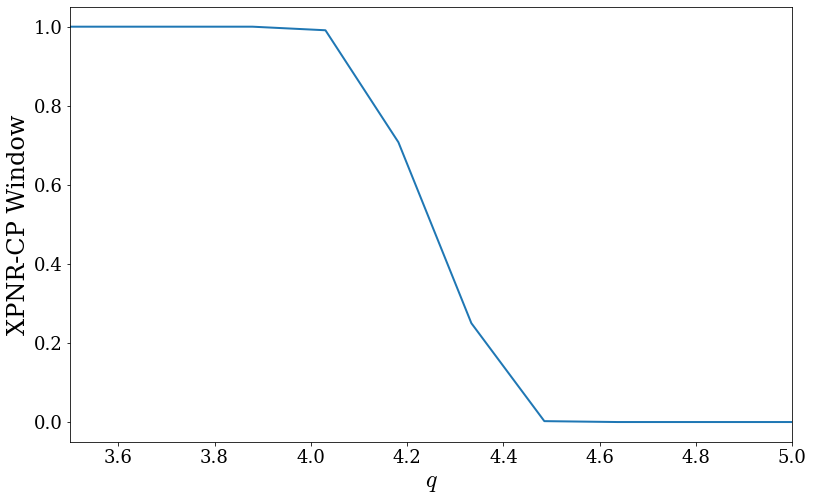

In [28]:
a1 = 0.2
theta_LS = 0.6
q_range = linspace(1,16,100)

window = array( [ PNRwindow( q, a1, theta_LS ) for q in q_range ] )

figure( figsize=2*figaspect(0.618) )
plot( q_range, window, lw=2 )
axvline(8,ls='--',color='k',lw=2)
xlim(lim(q_range))

xref = 4
dx = 0.5
xlim( xref-dx,xref+2*dx )


xlabel('$q$')
ylabel('XPNR-CP Window')

Text(0, 0.5, 'XPNR-CP Window')

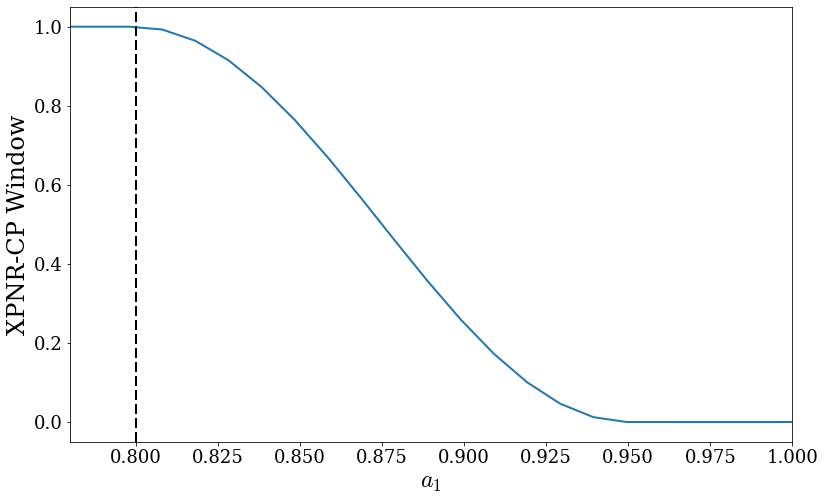

In [30]:
a1_range = linspace(0,1,100)
theta_LS = 0.6
q = 4.0

window = array( [ PNRwindow( q, a1, theta_LS ) for a1 in a1_range ] )

figure( figsize=2*figaspect(0.618) )
plot( a1_range, window,lw=2 )
axvline(0.8,ls='--',color='k',lw=2)
xlim(lim(a1_range))

xref = 0.8
dx = 0.02
xlim( xref-dx,xref+10*dx )

xlabel('$a_1$')
ylabel('XPNR-CP Window')

Text(0, 0.5, 'XPNR-CP Window')

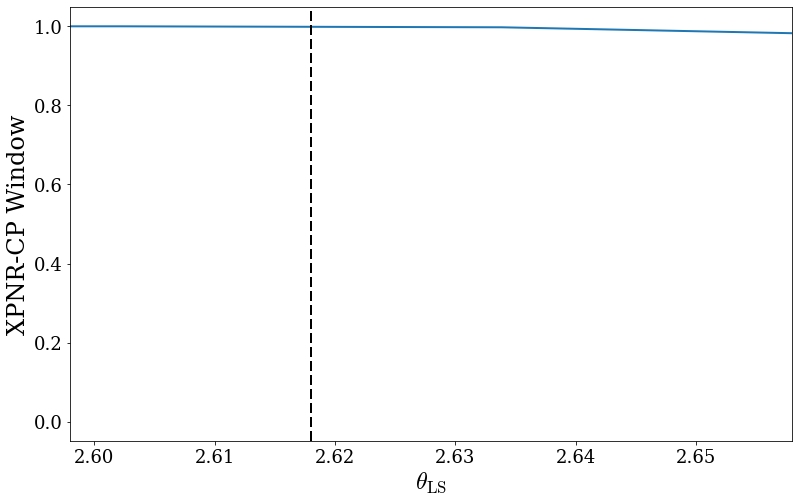

In [31]:


a1_range = 0.6
theta_LS_range = linspace(0,pi,100)
q = 4.0

window = array( [ PNRwindow( q, a1, theta_LS ) for theta_LS in theta_LS_range ] )

figure( figsize=2*figaspect(0.618) )
plot( theta_LS_range, window,lw=2 )
axvline(150*pi/180,ls='--',color='k',lw=2)
xlim(lim(theta_LS_range))

xref = 150*pi/180
dx = 0.02
xlim( xref-dx,xref+2*dx )

xlabel(r'$\theta_\mathrm{LS}$')
ylabel('XPNR-CP Window')

In [32]:
a1_range = linspace(0,1,20)
q_range = linspace(1,16,20)
theta_LS = 30*pi/180

window = zeros( (len(a1_range),len(q_range)) )
for j,q in enumerate(q_range):
    for k,a1 in enumerate(a1_range):
        window[j,k] = PNRwindow( q, a1, theta_LS )


(20, 2)


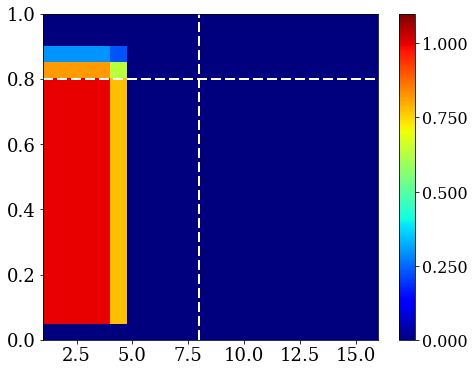

In [33]:
figure( figsize=1.5*figaspect(0.8) )
domain = vstack([q_range, a1_range]).T;
print( domain.shape )
splot( domain, window.T, ax=gca() )
axvline(8,ls='--',c='w',lw=2)
axhline( 0.8 ,ls='--',c='w',lw=2)